In [111]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import f1_score, hamming_loss, accuracy_score
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = "second" # "second" "third"
path = "./second_dataset/mbti_1.csv"
seed = 0
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.backends.cudnn.benchmark = True
# Data
train_fraction = 0.80
val_fraction = 0.10
vocab_size = 20000
seq_len = 256 
vocab = "vocab"
preset_token = ["__pad__", "__url__", "__sep__", "__tar__", "__unk__"]
token_col = "tokens"
target_cols = ["I_E", "N_S", "T_F", "J_P"]
pad_id = 0
targets = 4

# Model
cfg_embed_dim = 384 # (128, 256, 384, 512) 
cfg_hidden_dim = 384 # (128, 256, 384, 512)
cfg_num_layers = 1 # (1, 2, 3)
cfg_dropout = 0.4 # 0.2-0.5
cfg_bidirectional = False

# Train
cfg_batch_size = 64 # (64, 128, 256)
cfg_lr = 1e-3        # (5e-5, 1e-4, 5e-4, 1e-3) 
cfg_weight_decay = 5e-4 # (5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2)
cfg_epochs = 20
cfg_max_grad_norm = 1.0 # (0.5–2.0)
cfg_weight_cap = 50 # [20, 50, 100]

cfg_thresholds = [0.5]*4 #[0.44, 0.31, 0.6, 0.96], best thresholds rely on model

if dataset == "third":#
    path = "./third_dataset/MBTI 500.csv"
    # Model
    cfg_embed_dim = 512 # (128, 256, 384, 512) 
    cfg_hidden_dim = 128 # (128, 256, 384, 512)
    cfg_num_layers = 2 # (1, 2, 3)
    cfg_dropout = 1.0 # 0.2-0.5
    cfg_bidirectional = False

    # Train
    cfg_batch_size = 64 # (64, 128, 256)
    cfg_lr = 1e-3        # (5e-5, 1e-4, 5e-4, 1e-3) 
    cfg_weight_decay = 5e-4 # (5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2)
    cfg_max_grad_norm = 0.4 # (0.5–2.0)
    cfg_weight_cap = 50 # [20, 50, 100]


In [112]:
# Data curation
import regex
def preprocess_df(df):
    posts = df["posts"]
    types = df["type"]
    
    posts = posts.replace(r"http[^\s|]+", " __url__ ", regex=True)
    posts = posts.str.replace("|||", " __sep__ ", regex=False)
    posts = posts.replace(r"(?i)\b[IE][NS][TF][JP]\b", " __tar__ ", regex=True) # i.e. INTP, ENFJ
    posts = posts.replace(r"\s+", " ", regex=True) # remove excess spaces
    rx = regex.compile(r"[^_\p{White_Space}\p{scx=Latin}5\p{Nd}\p{Emoji}]+") # remove everything that is not _, " ", latin, or emojis
    posts = posts.apply(lambda s: rx.sub("", s))
    
    types = types.replace(r"I|N|T|J", "1", regex=True)
    types = types.replace(r"E|S|F|P", "0", regex=True)
    
    df["posts"] = posts
    df["type"] = types
    
    df = df.sample(frac=1, random_state=seed).reset_index(drop=True)

    df[["I_E", "N_S", "T_F", "J_P"]] = (
        df["type"].apply(lambda s: pd.Series([int(c) for c in s]))
    ).astype("int32")

    return df

In [113]:
# cut off data to balance distribution
import pandas as pd

def equal_dist_sample(df, total_n=10_000, seed=seed) -> pd.DataFrame:
    counts = df["type"].value_counts()
    amt_classes = len(counts)
    amt_per_class = total_n // amt_classes
    need = pd.Series(amt_per_class, index=counts.index)
    out = need.clip(upper=counts)
    


    parts = [
        df[df["type"] == cls].sample(n=int(out[cls]), random_state=seed)
        for cls in out.index
        if int(out[cls]) > 0
    ]
    out = pd.concat(parts, ignore_index=True).sample(frac=1, random_state=seed).reset_index(drop=True)
    return out
df = pd.read_csv(path)
counts = df["type"].value_counts()
print(counts)
print(sum(counts.values))


type
INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: count, dtype: int64
8675


In [114]:
# train/test split
torch.manual_seed = seed
df = pd.read_csv(path)
df = preprocess_df(df)
if dataset == "third":
    df = equal_dist_sample(df)
print(df)
n = len(df)
n_train = int(train_fraction * n)
n_val = int((val_fraction + train_fraction) * n)

train_df = df[ : n_train]
val_df = df[n_train : n_val]
test_df = df[n_val : ]

      type                                              posts  I_E  N_S  T_F  \
0     1000  Dear __tar__ Mother I wish you were less of a ...    1    0    0   
1     1101  To me I think you guys may be over analyzing i...    1    1    0   
2     0100  NIHM While NIHM has her __tar__ husband Ive go...    0    1    0   
3     1110  I want 5 kids  an astronucleartheoretical phys...    1    1    1   
4     1000  I have the same thing as well Ive noticed that...    1    0    0   
...    ...                                                ...  ...  ...  ...   
8670  1100  Hey It seems like you have a great foundation ...    1    1    0   
8671  1101  Dear __tar__ mother When I started my very fir...    1    1    0   
8672  1110  Oh ENTJs how can you be scary and exciting at ...    1    1    1   
8673  0101  Hi __tar__  and welcome to the forumwink __sep...    0    1    0   
8674  0110  Interesting youve gone from Se dominant to Ne ...    0    1    1   

      J_P  
0       0  
1       1  
2  

In [115]:
# Tokenizing function

from tokenizers import Tokenizer
from tokenizers.models import WordPiece
from tokenizers.trainers import WordPieceTrainer
from tokenizers.normalizers import BertNormalizer
from tokenizers.pre_tokenizers import BertPreTokenizer
from pathlib import Path


def tokenize():
    tok = Tokenizer(WordPiece(unk_token="__unk__"))
    tok.normalizer = BertNormalizer(lowercase=True)
    tok.pre_tokenizer = BertPreTokenizer()

    trainer = WordPieceTrainer(vocab_size=vocab_size, special_tokens=preset_token)
    tok.train_from_iterator(train_df["posts"], trainer=trainer)

    tok.save(str(Path(path).parent / "tokenizer.json"))
    print("saved at:", str(Path(path).parent / "tokenizer.json"))
    return tok




In [116]:
# tokenizer
if dataset == "third":
    tok = tokenize()
else:
    try:
        tok = Tokenizer.from_file(str(Path(path).parent / "tokenizer.json"))
    except:
        print("creating new Tokenizer")
        tok = tokenize()

pad_id = tok.token_to_id("__pad__")
tok.enable_padding(length=seq_len, pad_id=pad_id, pad_token="__pad__")
tok.enable_truncation(max_length=seq_len)

def add_input_ids(df, tok, text_col="posts", out_col=token_col):
    encs = tok.encode_batch(df[text_col].astype(str).tolist())
    df = df.copy()
    df[out_col] = [e.ids for e in encs]
    return df

train_df = add_input_ids(train_df, tok, text_col="posts", out_col=token_col)
val_df   = add_input_ids(val_df,   tok, text_col="posts", out_col=token_col)
test_df  = add_input_ids(test_df,  tok, text_col="posts", out_col=token_col)

y_train = train_df[target_cols].to_numpy(dtype=np.int32)
y_val = val_df[target_cols].to_numpy(dtype=np.int32)
y_test  = test_df[target_cols].to_numpy(dtype=np.int32)


In [117]:
# Majority Guessing baseline 

def eval(y_true, y_pred):
    exact_match = np.mean(np.all(y_true == y_pred, axis=1))
    per_label_acc = (y_true == y_pred).mean(axis=0)
    micro_f1 = f1_score(y_true, y_pred, average="micro", zero_division=0)
    macro_f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)
    h_loss = hamming_loss(y_true, y_pred)

    print("Exact match:", exact_match)
    print("Hamming loss:", h_loss)
    print("Micro F1:", micro_f1)
    print("Macro F1:", macro_f1)
    print("Per-label acc [I_E, N_S, T_F, J_P]:", per_label_acc)



priors = y_train.mean(axis=0)
majority_bits = (priors >= 0.5).astype(np.int32)
y_pred_majority = np.tile(majority_bits, (len(y_test), 1))
eval(y_test, y_pred_majority)

Exact match: 0.20622119815668202
Hamming loss: 0.31336405529953915
Micro F1: 0.7204522096608428
Macro F1: 0.4465365558676654
Per-label acc [I_E, N_S, T_F, J_P]: [0.76958525 0.84562212 0.52073733 0.61059908]


In [118]:
# balanced ce loss function
# class weights
eps = 1e-4
ce_pos_rate = np.clip(y_train.mean(axis=0), eps, 1-eps)  # pos_rate je Dimension

w0 = 0.5 / (1 - ce_pos_rate)
w1 = 0.5 / ce_pos_rate

class_weights = []
for target in range(targets):
    class_weights.append(torch.tensor([w0[target], w1[target]], dtype=torch.float32, device=device))
    
def balanced_ce_loss(logits, y, class_weights=class_weights):
    loss = 0.0
    for target in range(targets):
        loss = loss + nn.functional.cross_entropy(logits[:, target, :], y[:, target], weight=class_weights[target])
    return loss / targets

In [119]:
# model class
class LSTM_MBTI(nn.Module):
    def __init__(self, embed_dim=cfg_embed_dim, hidden_dim=cfg_hidden_dim, num_layers=cfg_num_layers, dropout=cfg_dropout, bidirectional=cfg_bidirectional):
        super().__init__()
        self.bidirectional = bidirectional

        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embed_dim,
            padding_idx=pad_id
        )

        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            batch_first=True,
            bidirectional=bidirectional
        )
        out_dim = hidden_dim * (2 if bidirectional else 1)
        
        self.head = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(out_dim, 8)
        )

    def forward(self, input_ids):
        x = self.embedding(input_ids)
        out, _ = self.lstm(x)

        mask = (input_ids != pad_id).to(out.dtype)
        denom = mask.sum(dim=1, keepdim=True).clamp(min=1.0)
        pooled = (out * mask.unsqueeze(-1)).sum(dim=1) / denom

        return self.head(pooled).view(-1, 4, 2)


In [120]:
# dataset
from torch.utils.data import TensorDataset
def make_ds(df):
    x = torch.tensor(np.stack(df[token_col].to_list()), dtype=torch.long)
    y = torch.tensor(df[target_cols].to_numpy(np.float32), dtype=torch.float32)
    return TensorDataset(x, y)

In [121]:
# data loaders
train_ds = make_ds(train_df)
val_ds   = make_ds(val_df)
test_ds   = make_ds(test_df)

cfg_train_loader = DataLoader(train_ds, batch_size=cfg_batch_size, shuffle=True, num_workers=0,
                        pin_memory=torch.cuda.is_available())
cfg_val_loader = DataLoader(val_ds, batch_size=cfg_batch_size, shuffle=False,
                        pin_memory=torch.cuda.is_available())
cfg_test_loader = DataLoader(test_ds, batch_size=cfg_batch_size, shuffle=False,
                        pin_memory=torch.cuda.is_available())

In [162]:
# train and eval
import torch
import torch.nn as nn
import time
import copy
from tqdm.auto import tqdm
from IPython.display import display, update_display
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from collections import deque

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    losses = []
    y_true_all = []
    y_pred_all = []
    probs_all = []

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True).long()

        logits = model(x)

        
        loss = balanced_ce_loss(logits, y)
        losses.append(loss.item())

        probs = torch.softmax(logits, dim=-1).cpu().numpy()
        y_true = y.cpu().numpy().astype(np.int32)
        
        y_pred = probs.argmax(-1).astype(np.int32)

        y_true_all.append(y_true)
        y_pred_all.append(y_pred)
        probs_all.append(probs)

    
    
    y_true_all = np.vstack(y_true_all)
    y_pred_all = np.vstack(y_pred_all)
    probs_all = np.vstack(probs_all)
    
    per_label_f1 = []
    ap_label = []
    for j in range(4):
        f1_j = f1_score(y_true_all[:, j], y_pred_all[:, j], average="macro", zero_division=0)
        per_label_f1.append(f1_j)
        ap1 = average_precision_score(y_true_all[:, j], probs_all[:, j, 1])
        ap0 = average_precision_score(1 - y_true_all[:, j], probs_all[:, j, 0])
        ap_sym = 0.5 * (ap0 + ap1)
        ap_label.append(ap_sym)
    macro_ap = np.mean(ap_label)

    # sklearn:
    exact = accuracy_score(y_true_all, y_pred_all)
    micro = f1_score(y_true_all, y_pred_all, average="micro", zero_division=0)
    macro = f1_score(y_true_all, y_pred_all, average="macro", zero_division=0)
    ham = hamming_loss(y_true_all, y_pred_all)
    per_label_acc = (y_true_all == y_pred_all).mean(axis=0).tolist()
    
    
    return {
        "loss": float(np.mean(losses)),
        "hamming_loss": float(ham),
        "exact": float(exact),
        "microF1": float(micro),
        "macroF1": float(macro),
        "macroAP": float(macro_ap),
        "per_label_acc": per_label_acc,
        "per_label_f1": per_label_f1,
    }

def train(model, epochs=cfg_epochs, lr=cfg_lr, weight_decay=cfg_weight_decay, max_grad_norm=cfg_max_grad_norm,
        train_loader=cfg_train_loader, val_loader=cfg_val_loader, output=True, save_all_epochs=False):
    model.to(device)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode="max",
        factor=0.5,
        patience=2,
        threshold=5e-3,
        threshold_mode="rel"
    )
    
    history = {
        "exact": [],
        "train_loss": [],
        "val_loss": [],
        "val_macroF1": [],
        "val_macroAP": [],
    }

    chosen_f1 = -np.inf
    best_state = None
    earliest_epoch=5
    f1_window = deque(maxlen=earliest_epoch)
    f1_window_means = [np.nan]*earliest_epoch
    f1_window_stds = [np.nan]*earliest_epoch
    state_epoch = 0
    val_display_id = "val_details"
    display("", display_id=val_display_id)
    pbar = tqdm(total=epochs)
    smoothed_best = -np.inf
    best_state = None
    states = [None]*earliest_epoch
    for epoch in range(1, epochs + 1):
        start = time.perf_counter()
        model.train()
        running = 0.0
        n_batches = 0

        for x, y in train_loader:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True).long()

            optimizer.zero_grad(set_to_none=True)
            logits = model(x)
            

            loss = balanced_ce_loss(logits, y)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

            optimizer.step()
            running += loss.item()
            n_batches += 1

        epoch_time = time.perf_counter() - start
        val = evaluate(model, val_loader)
        
        scheduler.step(val["macroAP"])
        
        train_loss_epoch = running / max(n_batches, 1)
        history["exact"].append(float(val["exact"]))
        history["train_loss"].append(float(train_loss_epoch))
        history["val_loss"].append(float(val["loss"]))
        history["val_macroF1"].append(float(val["macroF1"]))
        history["val_macroAP"].append(float(val["macroAP"]))
        pbar.set_description(f"Epoch {epoch}/{epochs}")
        if output:
            val_text = (f"VAL  loss={val['loss']:.3f} exact={val['exact']:.3f} hamming_loss={val['hamming_loss']:.3f} "
            f"microF1={val['microF1']:.3f} macroF1={val['macroF1']:.3f} "
            f"per_label_acc={np.round(val['per_label_acc'], 3)} per_label_f1={np.round(val['per_label_f1'], 3)}")
            update_display(val_text, display_id=val_display_id)
        else:
            print(f"macroF1={val["macroF1"]:.3f}")
            print(f"epoch_time={epoch_time:.2f}s")


        delta = 1e-2
        val_f1 = val["macroF1"]
        
        f1_window.append(val_f1)
        
        
        
        if epoch > earliest_epoch:
            smoothed = sum(f1_window) / len(f1_window)
            f1_window_means.append(np.mean(f1_window))
            f1_window_stds.append(np.std(f1_window))
            if save_all_epochs:
                states.append(copy.deepcopy(model.state_dict()))
            elif smoothed > smoothed_best + delta:
                smoothed_best = smoothed
                best_state = copy.deepcopy(model.state_dict())
                state_epoch = epoch
                chosen_f1 = val_f1
            
        pbar.set_postfix_str(f"macroF1={val['macroF1']:.3f} epoch_time={epoch_time:.2f}s")
        pbar.update(1)
        
    if best_state is not None:
        model.load_state_dict(best_state)
        print(f"loaded model from epoch {state_epoch}")
        
    
    epochs_r = range(1, len(history["train_loss"]) + 1)
    _, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    means = np.asarray(f1_window_means)
    stds = np.asarray(f1_window_stds)
    ax1.plot(epochs_r, history["val_macroF1"],  "b", label="val_macroF1")
    ax1.plot(epochs_r, history["val_macroAP"], "g", label="val_macroAP")
    ax1.plot(epochs_r, f1_window_means, "y", linestyle="dotted", label="f1 mean")
    ax1.fill_between(epochs_r, means - stds, means + stds, alpha=0.2, label="std")
    ax2.plot(epochs_r, history["exact"],  "r", label="exact")
    ax1.set_ylim(0.5, 0.75)
    ax1.set_ylabel("Score")
    ax1.set_xlim(1, len(epochs_r))
    ax1.xaxis.set_major_locator(mticker.MultipleLocator(1))
    ax1.grid(True, axis='x', which='major', linestyle='-', alpha=0.3)
    ax2.set_ylabel("Exact Match")
    ax1.legend()
    ax2.legend()
    plt.show()
    return model, chosen_f1, states


Tuning

batch_size=64, with learning rate=0.0001


'VAL  loss=0.732 exact=0.156 hamming_loss=0.379 microF1=0.682 macroF1=0.653 per_label_acc=[0.611 0.694 0.649 0.527] per_label_f1=[0.55  0.529 0.648 0.52 ]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 20


C:\Users\jeldr\AppData\Local\Temp\ipykernel_5436\2399353913.py:183: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "y-" (-> linestyle='-'). The keyword argument will take precedence.
  ax1.plot(epochs_r, f1_window_means, "y-", linestyle="dotted", label="f1 mean")


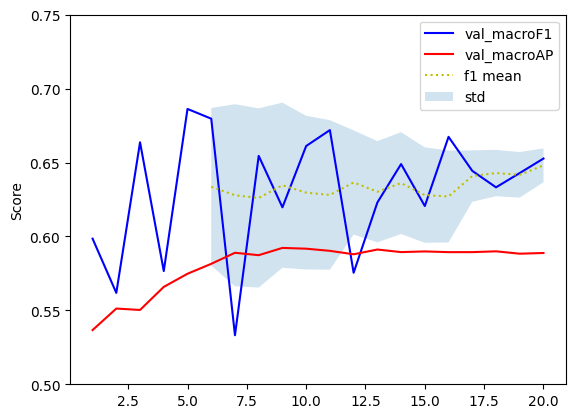

current_best_score=-inf max_val=0.653 current best lr=0.0001 current best batch size=64
batch_size=64, with learning rate=0.0005


'VAL  loss=1.259 exact=0.190 hamming_loss=0.340 microF1=0.723 macroF1=0.676 per_label_acc=[0.662 0.78  0.651 0.547] per_label_f1=[0.563 0.546 0.646 0.533]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 11


C:\Users\jeldr\AppData\Local\Temp\ipykernel_5436\2399353913.py:183: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "y-" (-> linestyle='-'). The keyword argument will take precedence.
  ax1.plot(epochs_r, f1_window_means, "y-", linestyle="dotted", label="f1 mean")


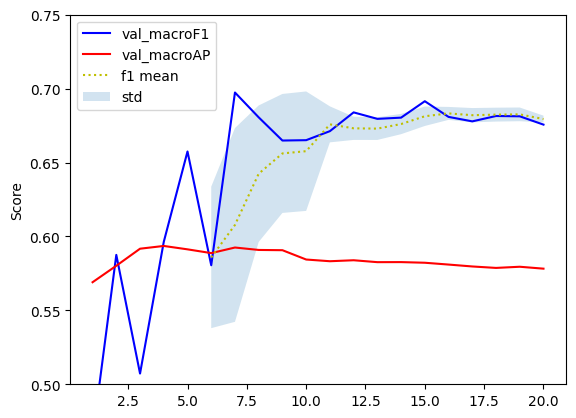

current_best_score=-inf max_val=0.671 current best lr=0.0005 current best batch size=64
batch_size=64, with learning rate=0.001


'VAL  loss=2.296 exact=0.225 hamming_loss=0.324 microF1=0.747 macroF1=0.691 per_label_acc=[0.715 0.83  0.646 0.512] per_label_f1=[0.551 0.575 0.641 0.504]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 11


C:\Users\jeldr\AppData\Local\Temp\ipykernel_5436\2399353913.py:183: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "y-" (-> linestyle='-'). The keyword argument will take precedence.
  ax1.plot(epochs_r, f1_window_means, "y-", linestyle="dotted", label="f1 mean")


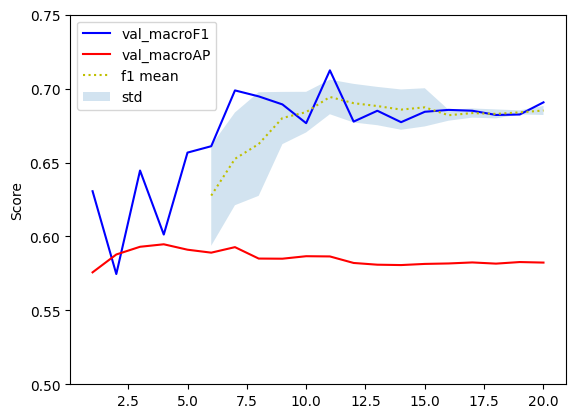

current_best_score=-inf max_val=0.712 current best lr=0.001 current best batch size=64
batch_size=128, with learning rate=0.0001


'VAL  loss=0.680 exact=0.150 hamming_loss=0.398 microF1=0.654 macroF1=0.630 per_label_acc=[0.608 0.611 0.659 0.529] per_label_f1=[0.546 0.498 0.656 0.517]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 12


C:\Users\jeldr\AppData\Local\Temp\ipykernel_5436\2399353913.py:183: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "y-" (-> linestyle='-'). The keyword argument will take precedence.
  ax1.plot(epochs_r, f1_window_means, "y-", linestyle="dotted", label="f1 mean")


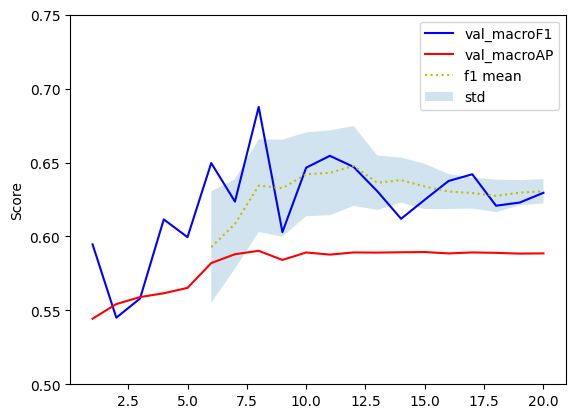

current_best_score=-inf max_val=0.712 current best lr=0.001 current best batch size=64
batch_size=128, with learning rate=0.0005


'VAL  loss=1.120 exact=0.197 hamming_loss=0.346 microF1=0.719 macroF1=0.675 per_label_acc=[0.664 0.768 0.641 0.543] per_label_f1=[0.572 0.558 0.639 0.531]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 17


C:\Users\jeldr\AppData\Local\Temp\ipykernel_5436\2399353913.py:183: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "y-" (-> linestyle='-'). The keyword argument will take precedence.
  ax1.plot(epochs_r, f1_window_means, "y-", linestyle="dotted", label="f1 mean")


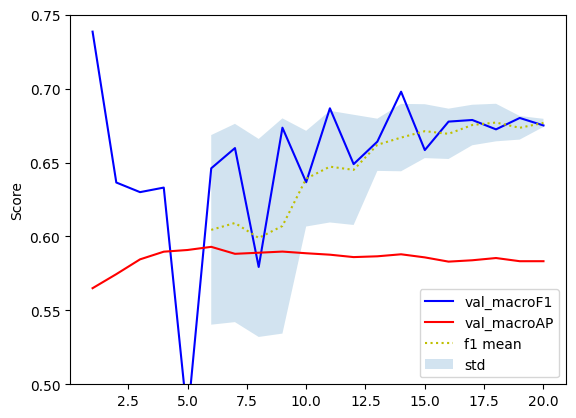

current_best_score=-inf max_val=0.712 current best lr=0.001 current best batch size=64
batch_size=128, with learning rate=0.001


'VAL  loss=2.088 exact=0.210 hamming_loss=0.324 microF1=0.745 macroF1=0.685 per_label_acc=[0.715 0.827 0.641 0.52 ] per_label_f1=[0.57  0.544 0.635 0.508]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 17


C:\Users\jeldr\AppData\Local\Temp\ipykernel_5436\2399353913.py:183: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "y-" (-> linestyle='-'). The keyword argument will take precedence.
  ax1.plot(epochs_r, f1_window_means, "y-", linestyle="dotted", label="f1 mean")


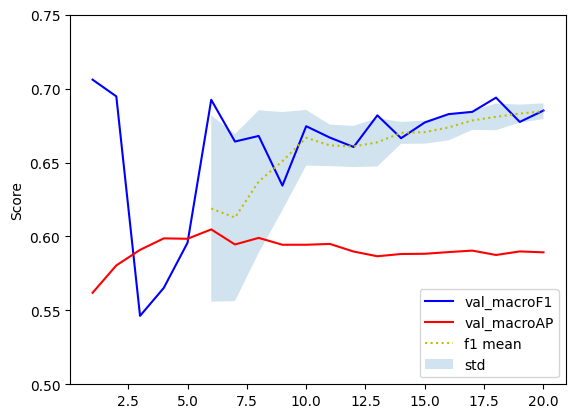

current_best_score=-inf max_val=0.712 current best lr=0.001 current best batch size=64
batch_size=256, with learning rate=0.0001


'VAL  loss=0.682 exact=0.134 hamming_loss=0.396 microF1=0.648 macroF1=0.609 per_label_acc=[0.627 0.629 0.624 0.534] per_label_f1=[0.55  0.52  0.61  0.514]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 14


C:\Users\jeldr\AppData\Local\Temp\ipykernel_5436\2399353913.py:183: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "y-" (-> linestyle='-'). The keyword argument will take precedence.
  ax1.plot(epochs_r, f1_window_means, "y-", linestyle="dotted", label="f1 mean")


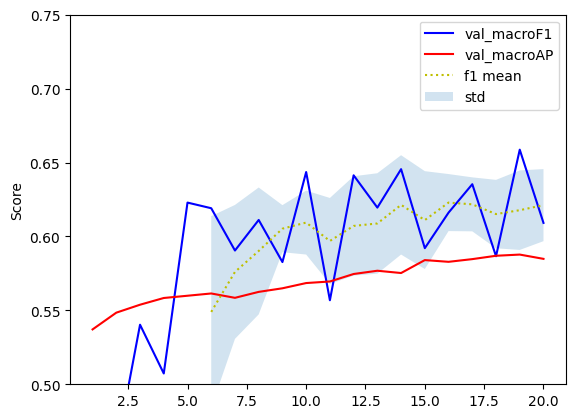

current_best_score=-inf max_val=0.712 current best lr=0.001 current best batch size=64
batch_size=256, with learning rate=0.0005


'VAL  loss=0.877 exact=0.159 hamming_loss=0.376 microF1=0.683 macroF1=0.643 per_label_acc=[0.601 0.715 0.642 0.539] per_label_f1=[0.533 0.543 0.642 0.515]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 16


C:\Users\jeldr\AppData\Local\Temp\ipykernel_5436\2399353913.py:183: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "y-" (-> linestyle='-'). The keyword argument will take precedence.
  ax1.plot(epochs_r, f1_window_means, "y-", linestyle="dotted", label="f1 mean")


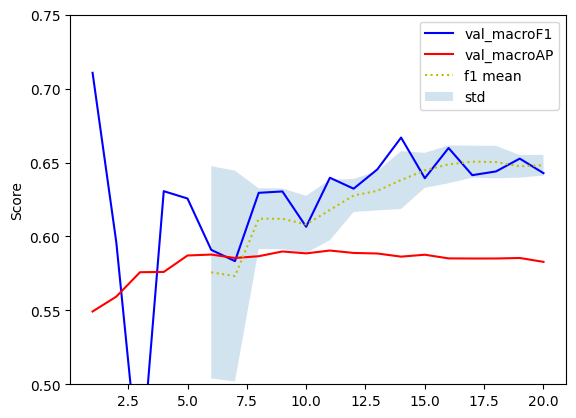

current_best_score=-inf max_val=0.712 current best lr=0.001 current best batch size=64
batch_size=256, with learning rate=0.001


'VAL  loss=1.513 exact=0.213 hamming_loss=0.334 microF1=0.731 macroF1=0.682 per_label_acc=[0.682 0.78  0.644 0.558] per_label_f1=[0.571 0.52  0.641 0.541]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 12


C:\Users\jeldr\AppData\Local\Temp\ipykernel_5436\2399353913.py:183: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "y-" (-> linestyle='-'). The keyword argument will take precedence.
  ax1.plot(epochs_r, f1_window_means, "y-", linestyle="dotted", label="f1 mean")


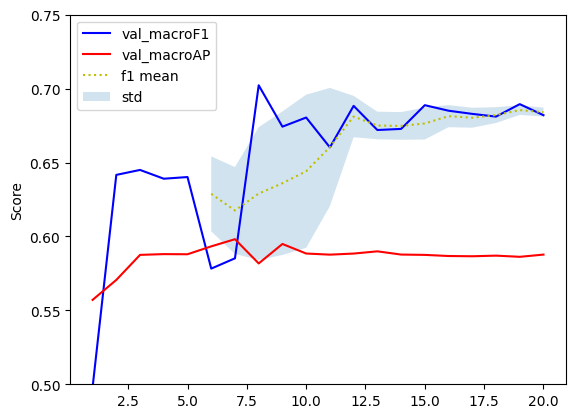

current_best_score=-inf max_val=0.712 current best lr=0.001 current best batch size=64


In [ ]:
# tune batch_size and learning rate
iterate_batch_size = [64, 128, 256]
iterate_lr = [1e-4, 5e-4, 1e-3]
max_val  = -np.inf
best_batch_size = -np.inf
best_lr = -np.inf
for batch_size in iterate_batch_size:
    
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                        pin_memory=torch.cuda.is_available())
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False,
                        pin_memory=torch.cuda.is_available())
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False,
                        pin_memory=torch.cuda.is_available())
    
    for lr in iterate_lr:
        model = LSTM_MBTI()
        print(f"\033[31mbatch_size={batch_size}, with learning rate={lr}\033[0m")
        model, best_score, _ = train(model,
            train_loader=train_loader,
            val_loader=val_loader,
            lr=lr
        )
        val = evaluate(model, val_loader)
        if val["macroF1"] > max_val:
                max_val = val["macroF1"]
                best_batch_size = batch_size
                best_lr = lr
        print(f"current_best_score={best_score}",f"max_val={max_val:.3f}",f"\033[31mcurrent best lr={best_lr}", f"current best batch size={best_batch_size}\033[0m")

weight decay=1e-05


'VAL  loss=2.025 exact=0.221 hamming_loss=0.323 microF1=0.739 macroF1=0.677 per_label_acc=[0.701 0.812 0.645 0.55 ] per_label_f1=[0.569 0.567 0.638 0.526]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 10


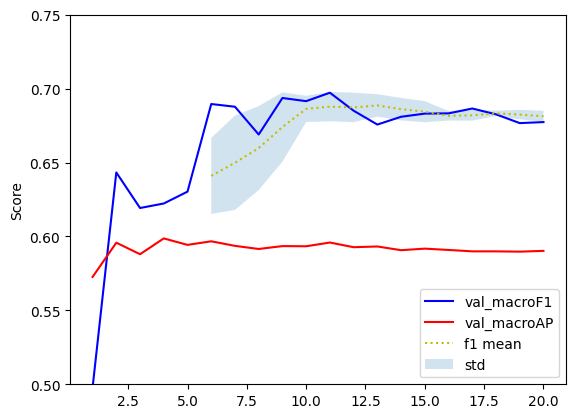

current_best_score=-inf max_val=0.692 current best weight_decay=1e-05
weight decay=5e-05


'VAL  loss=2.317 exact=0.217 hamming_loss=0.313 microF1=0.752 macroF1=0.691 per_label_acc=[0.704 0.83  0.659 0.557] per_label_f1=[0.541 0.571 0.655 0.533]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 10


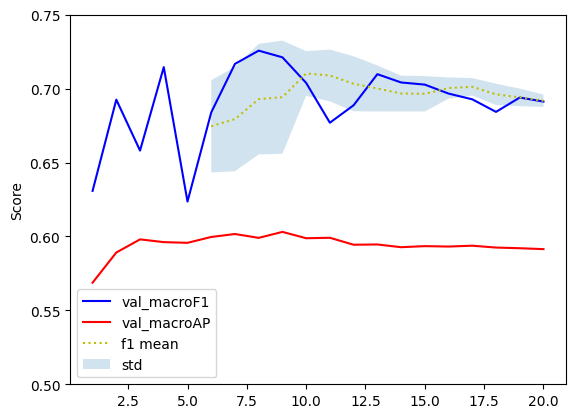

current_best_score=-inf max_val=0.704 current best weight_decay=5e-05
weight decay=0.0001


'VAL  loss=2.735 exact=0.231 hamming_loss=0.307 microF1=0.758 macroF1=0.700 per_label_acc=[0.735 0.819 0.652 0.566] per_label_f1=[0.587 0.534 0.647 0.548]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 12


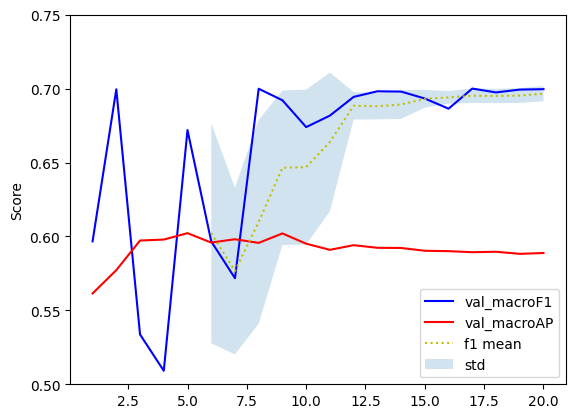

current_best_score=-inf max_val=0.704 current best weight_decay=5e-05
weight decay=0.0005


'VAL  loss=2.472 exact=0.240 hamming_loss=0.311 microF1=0.752 macroF1=0.689 per_label_acc=[0.714 0.824 0.656 0.564] per_label_f1=[0.56  0.577 0.654 0.533]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 12


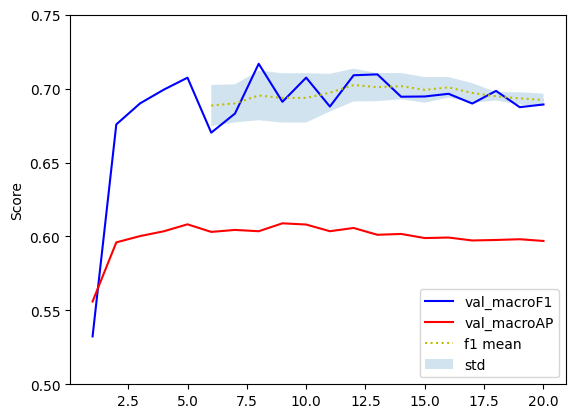

current_best_score=-inf max_val=0.709 current best weight_decay=0.0005
weight decay=0.001


'VAL  loss=2.282 exact=0.221 hamming_loss=0.312 microF1=0.753 macroF1=0.696 per_label_acc=[0.71  0.815 0.666 0.561] per_label_f1=[0.552 0.552 0.661 0.541]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 12


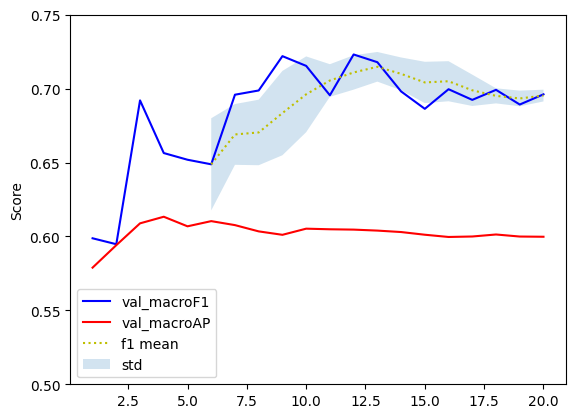

current_best_score=-inf max_val=0.723 current best weight_decay=0.001
weight decay=0.005


'VAL  loss=2.620 exact=0.249 hamming_loss=0.305 microF1=0.760 macroF1=0.700 per_label_acc=[0.736 0.824 0.639 0.581] per_label_f1=[0.556 0.55  0.634 0.562]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 15


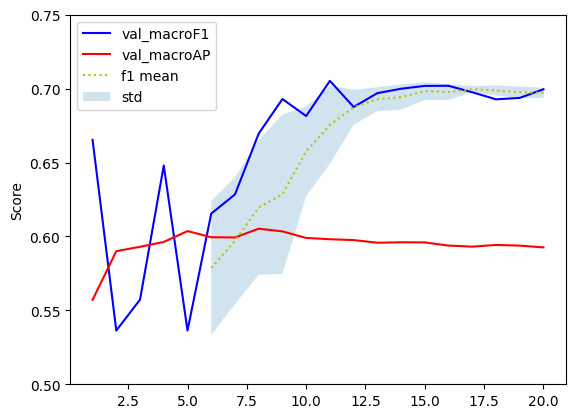

current_best_score=-inf max_val=0.723 current best weight_decay=0.001
weight decay=0.01


'VAL  loss=2.256 exact=0.223 hamming_loss=0.328 microF1=0.736 macroF1=0.677 per_label_acc=[0.67  0.806 0.654 0.557] per_label_f1=[0.527 0.508 0.647 0.535]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 12


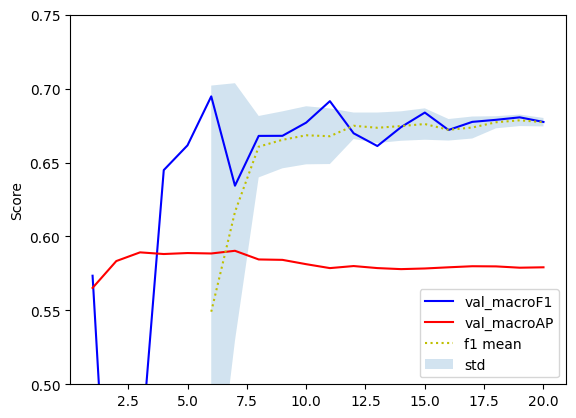

current_best_score=-inf max_val=0.723 current best weight_decay=0.001


In [ ]:
# tune weight_decay
iterate_weight_decay = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2]
max_val  = -np.inf
best_weight_decay = -np.inf
for weight_decay in iterate_weight_decay:
        model = LSTM_MBTI()
        print(f"\033[31mweight decay={weight_decay}\033[0m")
        model, best_score, _ = train(model, weight_decay=weight_decay, output=True)
        val = evaluate(model, cfg_val_loader)
        if val["macroF1"] > max_val:
                max_val = val["macroF1"]
                best_weight_decay = weight_decay
        print(f"current_best_score={best_score}",f"max_val={max_val:.3f}",f"\033[31mcurrent best weight_decay={best_weight_decay}\033[0m")

dropout=0.2


'VAL  loss=3.087 exact=0.239 hamming_loss=0.315 microF1=0.745 macroF1=0.678 per_label_acc=[0.714 0.804 0.644 0.577] per_label_f1=[0.558 0.524 0.638 0.541]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 11


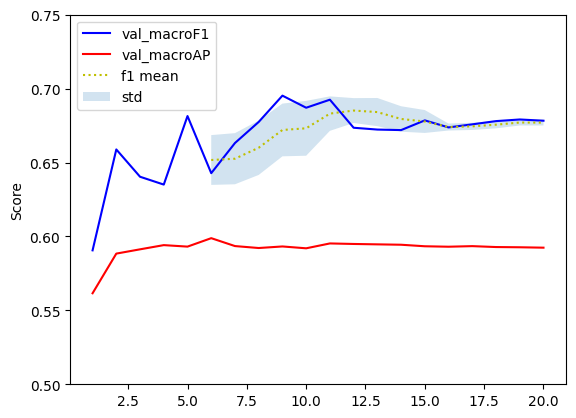

current_best_score=-inf max_val=0.692 current best dropout=0.2
dropout=0.3


'VAL  loss=2.646 exact=0.212 hamming_loss=0.320 microF1=0.743 macroF1=0.681 per_label_acc=[0.699 0.81  0.657 0.555] per_label_f1=[0.561 0.523 0.652 0.528]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 10


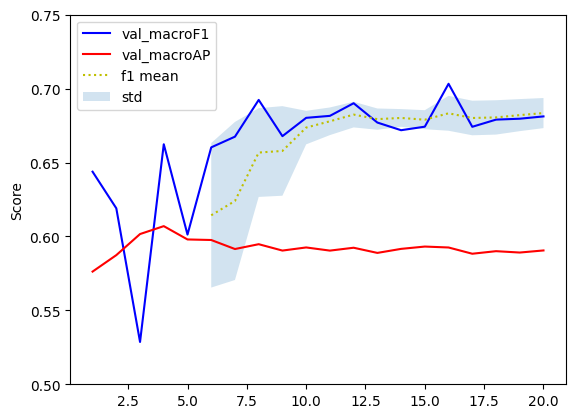

current_best_score=-inf max_val=0.692 current best dropout=0.2
dropout=0.4


'VAL  loss=2.841 exact=0.227 hamming_loss=0.313 microF1=0.753 macroF1=0.687 per_label_acc=[0.721 0.828 0.644 0.557] per_label_f1=[0.545 0.545 0.638 0.532]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 12


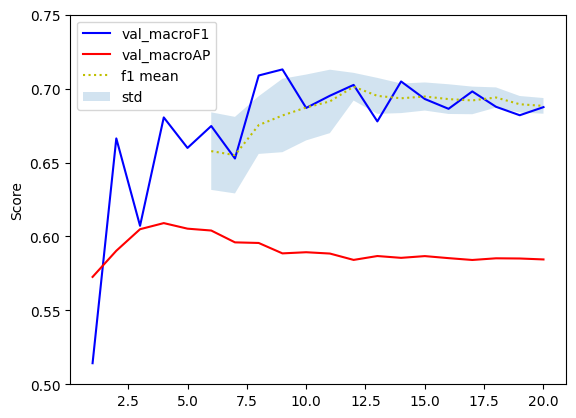

current_best_score=-inf max_val=0.702 current best dropout=0.4
dropout=0.5


'VAL  loss=2.466 exact=0.212 hamming_loss=0.330 microF1=0.736 macroF1=0.672 per_label_acc=[0.707 0.795 0.637 0.541] per_label_f1=[0.553 0.537 0.635 0.508]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 10


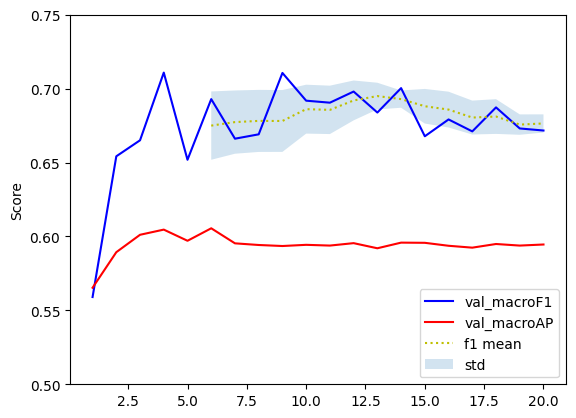

current_best_score=-inf max_val=0.702 current best dropout=0.4


In [ ]:
# tune dropout
iterate_dropout = [0.2, 0.3, 0.4, 0.5]
max_val  = -np.inf
best_dropout = -np.inf
for dropout in iterate_dropout:
        model = LSTM_MBTI(dropout=dropout)
        print(f"\033[31mdropout={dropout}\033[0m")
        model, best_score, _ = train(model)
        val = evaluate(model, cfg_val_loader)
        if val["macroF1"] > max_val:
                max_val = val["macroF1"]
                best_dropout = dropout
        print(f"current_best_score={best_score}",f"max_val={max_val:.3f}",f"\033[31mcurrent best dropout={best_dropout}\033[0m")

max_grad_norm=0.5


'VAL  loss=2.377 exact=0.212 hamming_loss=0.320 microF1=0.741 macroF1=0.674 per_label_acc=[0.684 0.827 0.655 0.552] per_label_f1=[0.529 0.576 0.649 0.519]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 16


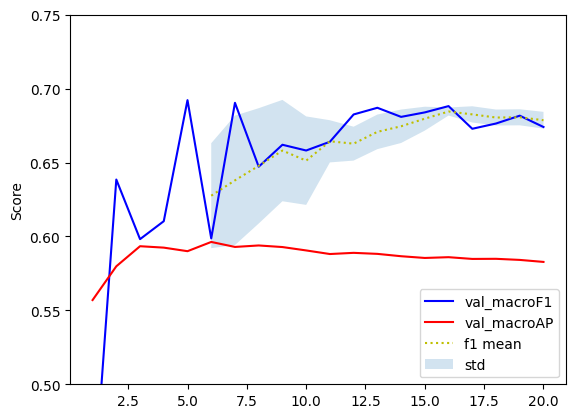

current_best_score=0.6881554141512629 max_val=0.688 current best max_grad_norm=0.5
max_grad_norm=1.0


'VAL  loss=2.375 exact=0.219 hamming_loss=0.307 microF1=0.758 macroF1=0.703 per_label_acc=[0.714 0.82  0.678 0.561] per_label_f1=[0.544 0.555 0.673 0.544]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 12


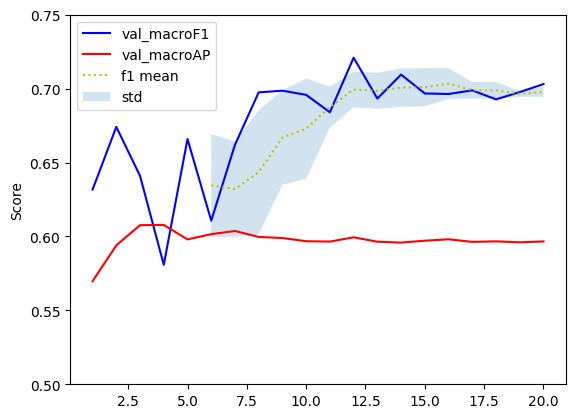

current_best_score=0.7209174005461251 max_val=0.721 current best max_grad_norm=1.0
max_grad_norm=1.5


'VAL  loss=2.557 exact=0.221 hamming_loss=0.316 microF1=0.746 macroF1=0.685 per_label_acc=[0.7   0.805 0.666 0.566] per_label_f1=[0.546 0.524 0.657 0.542]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 14


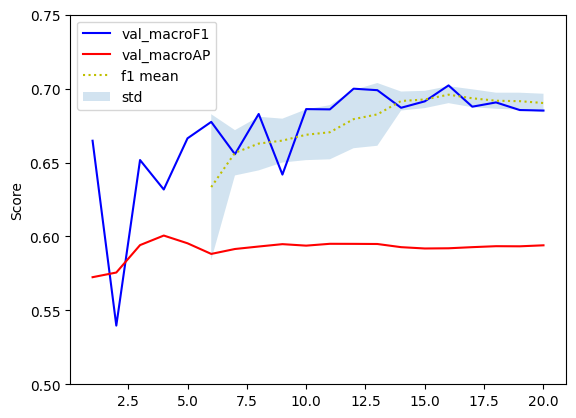

current_best_score=0.6870335366082602 max_val=0.721 current best max_grad_norm=1.0
max_grad_norm=2.0


'VAL  loss=2.345 exact=0.190 hamming_loss=0.328 microF1=0.735 macroF1=0.675 per_label_acc=[0.672 0.797 0.664 0.556] per_label_f1=[0.534 0.511 0.661 0.524]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 12


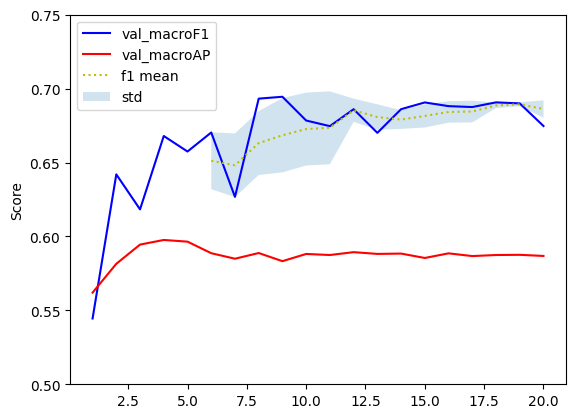

current_best_score=0.6860646516318372 max_val=0.721 current best max_grad_norm=1.0


In [ ]:
# tune max_grad_norm
iterate_max_grad_norm = [0.5, 1.0, 1.5, 2.0]
max_val  = -np.inf
best_max_grad_norm = -np.inf
for max_grad_norm in iterate_max_grad_norm:
        model = LSTM_MBTI()
        print(f"\033[31mmax_grad_norm={max_grad_norm}\033[0m")
        model, best_score, _ = train(model, max_grad_norm=max_grad_norm)
        val = evaluate(model, cfg_val_loader)
        if val["macroF1"] > max_val:
                max_val = val["macroF1"]
                best_max_grad_norm = max_grad_norm
        print(f"current_best_score={best_score}",f"max_val={max_val:.3f}",f"\033[31mcurrent best max_grad_norm={best_max_grad_norm}\033[0m")

hidden_dim=128


'VAL  loss=1.748 exact=0.191 hamming_loss=0.338 microF1=0.729 macroF1=0.676 per_label_acc=[0.66  0.795 0.644 0.55 ] per_label_f1=[0.53  0.537 0.64  0.532]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 11


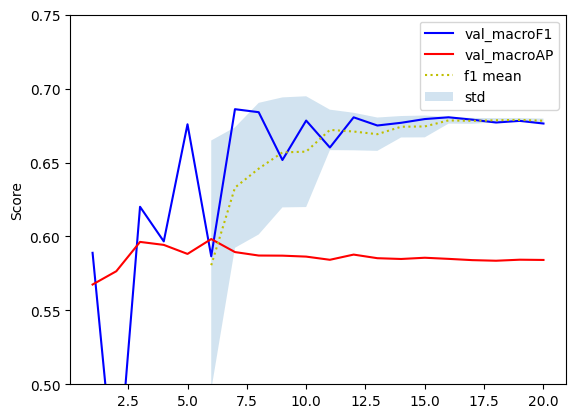

current_best_score=0.6601531734052116 max_val=0.660 current best hidden_dim=128
hidden_dim=256


'VAL  loss=2.140 exact=0.220 hamming_loss=0.317 microF1=0.747 macroF1=0.687 per_label_acc=[0.713 0.813 0.669 0.539] per_label_f1=[0.564 0.578 0.664 0.516]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 12


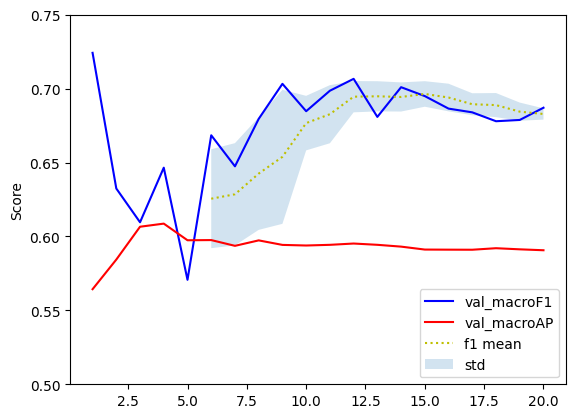

current_best_score=0.7065975191585592 max_val=0.707 current best hidden_dim=256
hidden_dim=384


'VAL  loss=3.138 exact=0.257 hamming_loss=0.299 microF1=0.764 macroF1=0.709 per_label_acc=[0.744 0.807 0.693 0.559] per_label_f1=[0.599 0.526 0.691 0.537]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 16


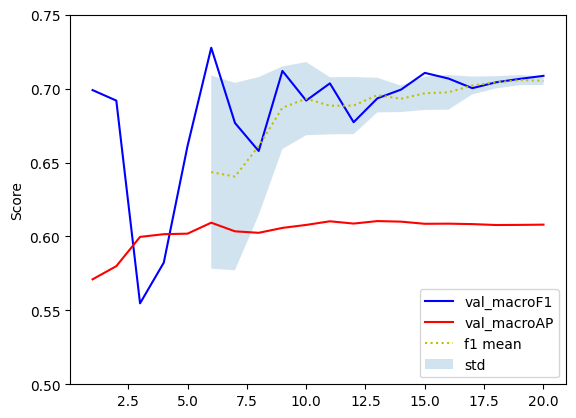

current_best_score=0.7067821856542718 max_val=0.707 current best hidden_dim=384
hidden_dim=512


'VAL  loss=3.710 exact=0.224 hamming_loss=0.311 microF1=0.752 macroF1=0.681 per_label_acc=[0.738 0.822 0.629 0.569] per_label_f1=[0.574 0.541 0.622 0.536]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 11


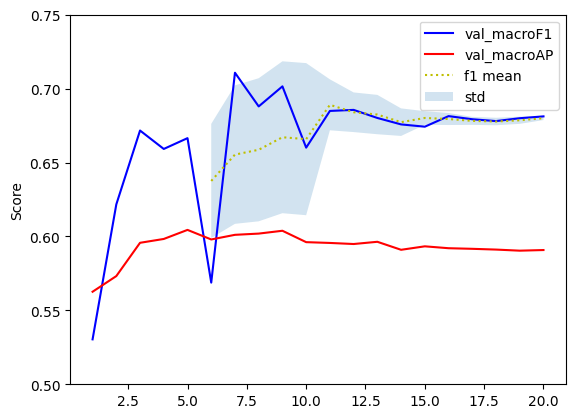

current_best_score=0.6848861317711045 max_val=0.707 current best hidden_dim=384


In [ ]:
# tune hidden_dim
iterate_hidden_dim = [128, 256, 384, 512]
max_val  = -np.inf
best_hidden_dim = -np.inf
for hidden_dim in iterate_hidden_dim:
        model = LSTM_MBTI(hidden_dim=hidden_dim)
        print(f"\033[31mhidden_dim={hidden_dim}\033[0m")
        model, best_score, _ = train(model)
        val = evaluate(model, cfg_val_loader)
        if val["macroF1"] > max_val:
                max_val = val["macroF1"]
                best_hidden_dim = hidden_dim
        print(f"current_best_score={best_score}",f"max_val={max_val:.3f}",f"\033[31mcurrent best hidden_dim={best_hidden_dim}\033[0m")

num layers=1


'VAL  loss=2.175 exact=0.228 hamming_loss=0.317 microF1=0.744 macroF1=0.688 per_label_acc=[0.696 0.798 0.656 0.582] per_label_f1=[0.55  0.543 0.649 0.56 ]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 9


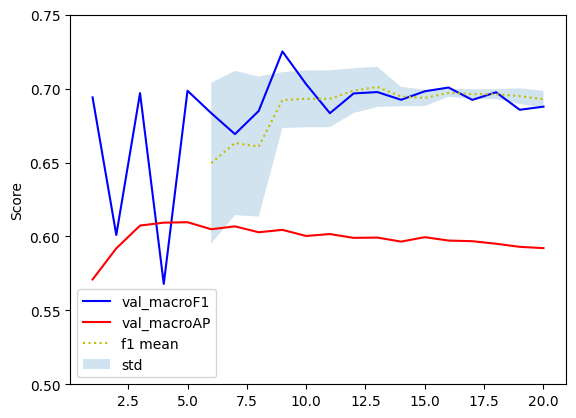

current_best_score=0.7251225631858007 max_val=0.725 current best num_layers=1
num layers=2


'VAL  loss=3.467 exact=0.226 hamming_loss=0.314 microF1=0.747 macroF1=0.691 per_label_acc=[0.677 0.819 0.668 0.581] per_label_f1=[0.533 0.558 0.662 0.557]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 16


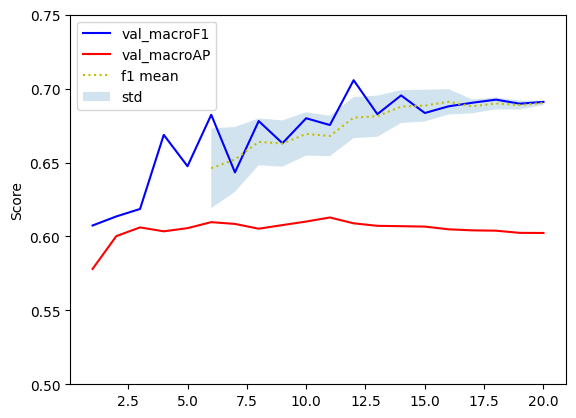

current_best_score=0.6880064092514723 max_val=0.725 current best num_layers=1
num layers=3


'VAL  loss=2.917 exact=0.245 hamming_loss=0.312 microF1=0.751 macroF1=0.679 per_label_acc=[0.725 0.814 0.653 0.561] per_label_f1=[0.544 0.535 0.648 0.521]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 9


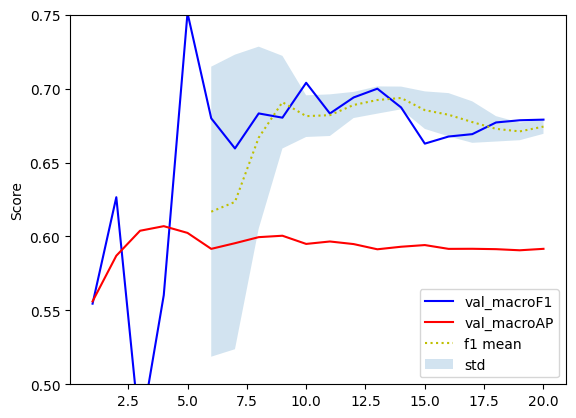

current_best_score=0.68033638643785 max_val=0.725 current best num_layers=1


In [ ]:
# tune num_layers
iterate_num_layers = [1, 2, 3]
max_val  = -np.inf
best_num_layers = -np.inf
for num_layers in iterate_num_layers:
        model = LSTM_MBTI(num_layers=num_layers)
        print(f"\033[31mnum layers={num_layers}\033[0m")
        model, best_score, _ = train(model)
        val = evaluate(model, cfg_val_loader)
        if val["macroF1"] > max_val:
                max_val = val["macroF1"]
                best_num_layers = num_layers
        print(f"current_best_score={best_score}",f"max_val={max_val:.3f}",f"\033[31mcurrent best num_layers={best_num_layers}\033[0m")

bidirectional=True


'VAL  loss=2.964 exact=0.231 hamming_loss=0.317 microF1=0.746 macroF1=0.684 per_label_acc=[0.722 0.8   0.654 0.555] per_label_f1=[0.562 0.537 0.649 0.528]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 9


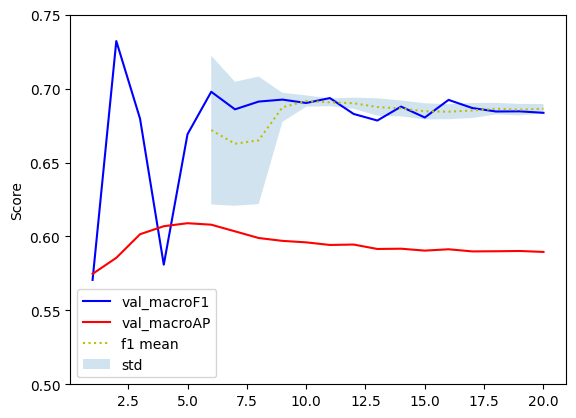

current_best_score=0.6925539129601839 max_val=0.693 Bidirectional=True
bidirectional=False


'VAL  loss=2.314 exact=0.228 hamming_loss=0.309 microF1=0.756 macroF1=0.703 per_label_acc=[0.737 0.8   0.668 0.561] per_label_f1=[0.595 0.521 0.664 0.545]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 12


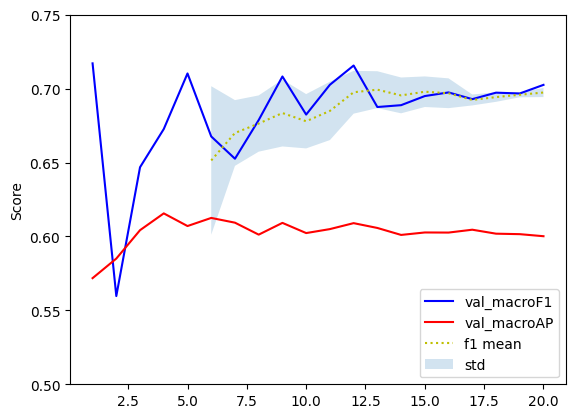

current_best_score=0.715608148907511 max_val=0.716 Bidirectional=False


In [ ]:
# test if bidirectional
iterate_directions = [True, False]
max_val  = -np.inf
best_directions = True
for directions in iterate_directions:
        model = LSTM_MBTI(bidirectional=directions)
        print(f"\033[31mbidirectional={directions}\033[0m")
        model, best_score, _ = train(model)
        val = evaluate(model, cfg_val_loader)
        if val["macroF1"] > max_val:
                max_val = val["macroF1"]
                best_directions = directions
        print(f"current_best_score={best_score}",f"max_val={max_val:.3f}",f"\033[31mBidirectional={best_directions}\033[0m")

embed dim=128


'VAL  loss=2.431 exact=0.233 hamming_loss=0.319 microF1=0.745 macroF1=0.689 per_label_acc=[0.692 0.803 0.653 0.577] per_label_f1=[0.546 0.535 0.65  0.552]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 13


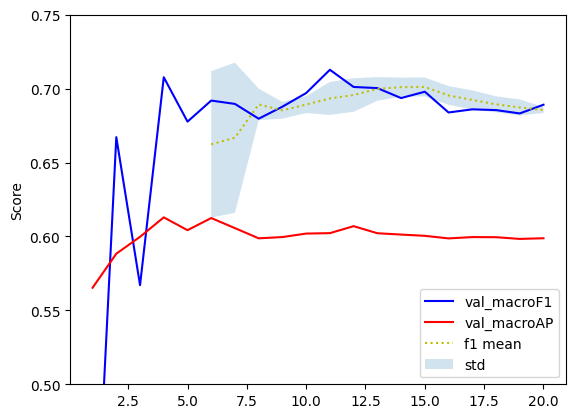

current_best_score=0.700345680974209 max_val=0.700 current best embed_dim=128
embed dim=256


'VAL  loss=2.870 exact=0.261 hamming_loss=0.294 microF1=0.766 macroF1=0.707 per_label_acc=[0.728 0.829 0.669 0.6  ] per_label_f1=[0.578 0.563 0.665 0.573]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 12


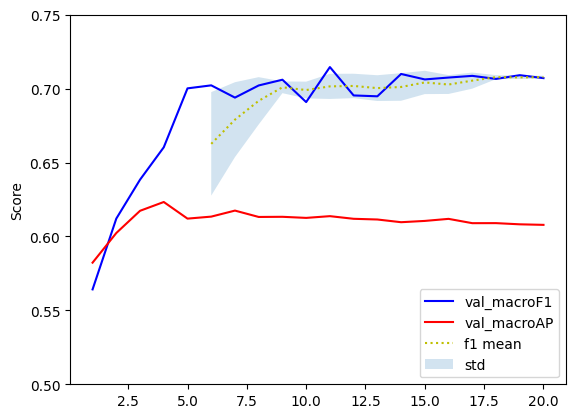

current_best_score=0.6953750240181553 max_val=0.700 current best embed_dim=128
embed dim=384


'VAL  loss=2.855 exact=0.270 hamming_loss=0.297 microF1=0.764 macroF1=0.707 per_label_acc=[0.712 0.818 0.692 0.591] per_label_f1=[0.56  0.524 0.689 0.563]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 9


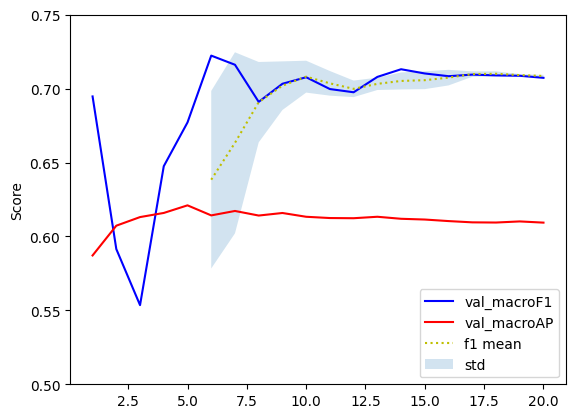

current_best_score=0.7032646065022973 max_val=0.703 current best embed_dim=384
embed dim=512


'VAL  loss=3.121 exact=0.225 hamming_loss=0.306 microF1=0.757 macroF1=0.696 per_label_acc=[0.721 0.828 0.669 0.558] per_label_f1=[0.571 0.553 0.666 0.533]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 7


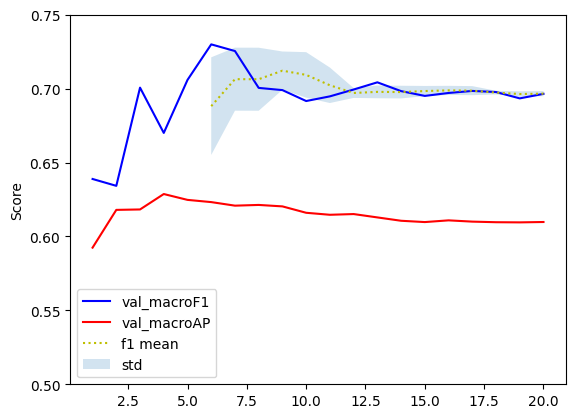

current_best_score=0.725403941440729 max_val=0.725 current best embed_dim=512


In [ ]:
# tune embed_dim
iterate_embed_dim = [128, 256, 384, 512]
max_val  = -np.inf
best_embed_dim = -np.inf
for embed_dim in iterate_embed_dim:
        model = LSTM_MBTI(embed_dim=embed_dim)
        print(f"\033[31membed dim={embed_dim}\033[0m")
        model, best_score, _ = train(model)
        val = evaluate(model, cfg_val_loader)
        if val["macroF1"] > max_val:
                max_val = val["macroF1"]
                best_embed_dim = embed_dim
        print(f"current_best_score={best_score}",f"max_val={max_val:.3f}",f"\033[31mcurrent best embed_dim={best_embed_dim}\033[0m")

Testing

'VAL  loss=3.085 exact=0.238 hamming_loss=0.310 microF1=0.753 macroF1=0.690 per_label_acc=[0.71  0.829 0.664 0.555] per_label_f1=[0.552 0.554 0.66  0.528]'

  0%|          | 0/20 [00:00<?, ?it/s]

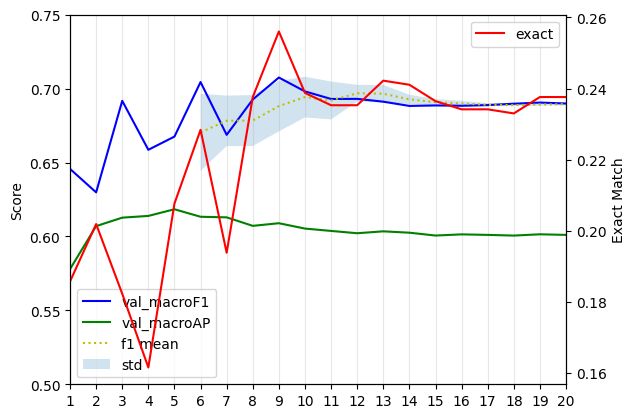

In [163]:
# training
model = LSTM_MBTI()
model, best_score, states = train(model, output=True, save_all_epochs=True)

In [174]:
chosen_epoch = 10
model.load_state_dict(states[chosen_epoch-1])

<All keys matched successfully>

In [175]:
# model eval
val = evaluate(model, cfg_val_loader)
print(f"VAL loss={val["loss"]:.3f} exact={val["exact"]:.3f} hamming_loss={val["hamming_loss"]:.3f} "
            f"microF1={val["microF1"]:.3f}\033[31m macroF1={val["macroF1"]:.3f}\033[0m per_label_acc={np.round(val["per_label_acc"], 3)} "
            f"per_label_f1={np.round(val["per_label_f1"], 3)}")

test = evaluate(model, cfg_test_loader)
print(f"TEST loss={test["loss"]:.3f} exact={test["exact"]:.3f} hamming_loss={test["hamming_loss"]:.3f} "
            f"microF1={test["microF1"]:.3f}\033[31m macroF1={test["macroF1"]:.3f}\033[0m per_label_acc={np.round(test["per_label_acc"], 3)} "
            f"per_label_f1={np.round(test["per_label_f1"], 3)}")

VAL loss=2.079 exact=0.239 hamming_loss=0.307 microF1=0.756 macroF1=0.698 per_label_acc=[0.71  0.83  0.669 0.562] per_label_f1=[0.555 0.571 0.663 0.544]
TEST loss=2.024 exact=0.222 hamming_loss=0.315 microF1=0.747 macroF1=0.694 per_label_acc=[0.727 0.783 0.666 0.566] per_label_f1=[0.6   0.542 0.662 0.545]


In [153]:
# save
save_path = str(Path(path).parent / "model.pt")
torch.save({
    "model_state_dict": model.state_dict(),
    "tok": tok,
}, save_path)


In [154]:
# load
ckpt = torch.load(str(Path(path).parent / "model.pt"), map_location="cuda", weights_only=False)

model = LSTM_MBTI()
model.load_state_dict(ckpt["model_state_dict"])
model.eval()

thresholds = ckpt.get("thresholds")
tok = ckpt.get("tok")


In [155]:
# tokenize input
def tokenize_text(text, tokenizer):
    text = regex.sub(r"http[^\s|]+", " __url__ ", text)
    text = text.replace("|||", " __sep__ ")
    text = regex.sub(r"(?i)\b[IE][NS][TF][JP]\b", " __tar__ ", text)
    text = regex.sub(r"\s+", " ", text)
    rx = regex.compile(r"[^_\p{White_Space}\p{scx=Latin}\p{Emoji}]+")
    text = rx.sub("", text)
    
    return tokenizer.encode(text)

In [156]:
# predict
zero_out = ["E", "S", "F", "P"]
one_out = ["I", "N", "T", "J"]
def predict(model, tokenized_text):
    model = model.to(device)
    model.eval()
    data = torch.tensor(tokenized_text.ids, dtype=torch.long).unsqueeze(0)
    data = data.to(device)
    with torch.no_grad():
        out = model(data).cpu()
    probs = torch.softmax(out, 2)
    print(np.round(probs, 3))
    bits = probs.argmax(dim=-1)
    mbti = "".join(one_out[i] if bits[0, i].item() == 1 else zero_out[i] for i in range(4))
    
    return mbti

In [157]:
# input
text = "current uni project make angry want dissociate snitch teacher l one work obviously problem even member team something shit redo hence contrast yet irony already contradict nice person unkind opinion easily waver really something else one several example deeply root notion homosexuality wrong unnatural vocal bring prod tell really nasty thing personally believe gay people le disagree step someone else shoe see thing another perspective bug heck yes everything say far paint insufferable prick yet still yet somehow though would lie admit glad friend thank head base word think unchecking box stop track user information stop use ad maybe kid nose even come hey chad thread way write seem like job target hell job great right grant writer also work shoe store every time think remind follow take test three year ago tell infp since take three year late leave college take twice sure tell intp think unusual surprise personality change time trust word gift require little effort act time touch best imo especially touch tend post majority post random act amazon really daily activity think post question however unsure would receive bad hard sum calculus paragraph good math hard learn yeah change fact mom might actually loosey goosey type girl first audio book work really well since majority book pretty much audio log anyway meme machine die normies entp clearly read fuck instruction say rate globally average preach choir right well incredibly quite drink least praise type fuck edly good little man fight memory hold real deal danny baranowsky story life right sell possession buy laptop move small city great cafe cuure live minimalist continue freelance alone tiny studio apartment go night alone walk soak light noise stranger sleep late every day think fe inferior ti dom however probably many intp reach certain stage maturity semi consciously amplify fe allow appreciate infj method communication instead confuse frustrate plus general intp tendency awe understand something actually fe amplification maybe accurately put consider one ti work arounds mention ahough actually believe ne actually work ti achieve course unconfirmed hypothesis want type first thing come mind soon read suppose write first thing come mind immediately start overanalysing first think even though think anything yet man understand feel well cause last damage good luck take world knit hedgehog though definitely need hedgehog good choice indeed sadly best way educational system find figure know shit history ask date maybe convert type exam interview ish type get broad relevant question answer real time yup mom since day one pretty toxic triangle parent esfj mom constantly try mold social butterfly abide societal norm dad infp constantly encourage weird person possibly turn pretty unique intp since exhibit social grace also able enter complete oddball territory parent try influence behavior year kind turn walk contradiction usually upside downside also extremely solitary seem general least attempt inflict others yes techno spend minute try decide username conflict advice think add credibility enought magic power swap true mean use past use present origin word concept try idiot last sentence extreme stress,INTP"
tokens = tokenize_text(text, tok)
out = predict(model, tokens)
print(out)

tensor([[[0.9930, 0.0070],
         [0.0000, 1.0000],
         [0.0000, 1.0000],
         [0.0000, 1.0000]]])
ENTJ
